In [1]:
import cello_multiplier as cm
from onto_lib import general_ontology_tools as got
import pandas as pd

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from C:\Users\julia\anaconda3\lib\site-packages\onto_lib\obo\EFO.17-01-30.obo ...


In [2]:
B_df, Z_df, labels, per_gene_mean, per_gene_std = cm.get_default_mats()

In [3]:
print(B_df)

            1,REACTOME_TRNA_AMINOACYLATION  \
SRX890545                        -0.047142   
SRX1067711                       -0.138811   
SRX1067710                        0.151608   
SRX762971                        -0.430337   
SRX762970                        -0.631706   
...                                    ...   
SRX3399308                        0.294573   
SRX3399309                        0.291303   
SRX3399310                        0.355084   
SRX3399311                        0.259266   
SRX3399312                        0.287875   

            2,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION  \
SRX890545                                       -0.061672   
SRX1067711                                      -0.072859   
SRX1067710                                       0.037346   
SRX762971                                        0.065104   
SRX762970                                        0.032056   
...                                                   ...   
SRX3399308          

In [4]:
#split 
from pathlib import Path
import json

splitdir = Path('split')

with open(splitdir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(splitdir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [5]:
train_Y_df = B_df[B_df.index.isin(train_egs)]
train_Y_df.shape

(3609, 258)

In [6]:
test_Y_df = B_df[B_df.index.isin(validation_egs)]
test_Y_df.shape

(684, 258)

In [7]:
# create list of samples by celltypes
from sklearn.preprocessing import MultiLabelBinarizer

sample2types = {
            sample: list(map(got.get_term_name, types_ids))
            for sample, types_ids in labels.items()
        }

types_per_b_samples = B_df.index.map(sample2types).values


mlb = MultiLabelBinarizer()
types_per_b_samples = B_df.index.map(sample2types).values

train_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_df.index)

celltypes = train_dummies.columns.tolist()

type2samples = {
            type_: train_dummies.index[train_dummies[type_]== 1].tolist()
            for type_ in celltypes
        }



In [8]:
import statistics

samplesizes = []
for celltype in type2samples:
    n = len(type2samples[celltype])
    samplesizes += [n]
mean_samplesize = int(statistics.mean(samplesizes))

In [9]:
mean_samplesize

200

In [10]:
# create target list for given cell type with 1 being that cell type and 0 being any other cell type
def set_target(celltype, type2samples, train_Y_df, test_Y_df, oversample):
    samplelist = type2samples[celltype]
    samplelist_train = [x for x in samplelist if x in train_Y_df.index.values]
    samplelist_test = [x for x in samplelist if x in test_Y_df.index.values]
    
    if(oversample == True and len(samplelist_train) > 0 and len(samplelist_test) >0):
        len_negative_train = len(train_Y_df)-len(samplelist_train)
        len_positive_train = len(samplelist_train)
        diff_train = len_negative_train - len_positive_train
        
        if(diff_train > 0):
            df_train = train_Y_df.loc[samplelist_train].sample(n=diff_train,replace = True,random_state=111)
            train_Y_df = train_Y_df.append(df_train)
        
        len_negative_test = len(test_Y_df)-len(samplelist_test)
        len_positive_test = len(samplelist_test)
        diff_test = len_negative_test - len_positive_test
        
        if(diff_test > 0):
            df_test = test_Y_df.loc[samplelist_test].sample(n=diff_test,replace = True, random_state=111)
            test_Y_df = test_Y_df.append(df_test)
        
        
    
    target_train = pd.Series(0,index = train_Y_df.index)
    target_train.loc[samplelist_train] = 1
    
    target_test = pd.Series(0,index = test_Y_df.index)
    target_test.loc[samplelist_test] = 1
    
  
    
    train_Y_transformed = scaler.transform(train_Y_df)
    test_Y_transformed = scaler.transform(test_Y_df)
    
    return(target_train.values, target_test.values,train_Y_transformed, test_Y_transformed )

In [11]:
# scaling
from sklearn.preprocessing import StandardScaler#

scaler = StandardScaler().fit(B_df)


In [12]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

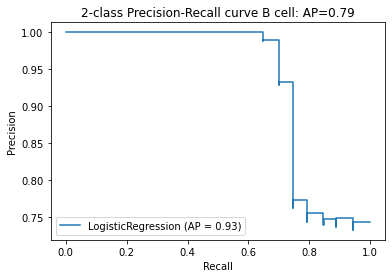

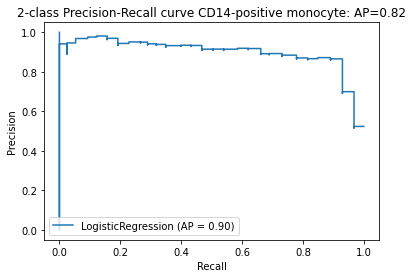

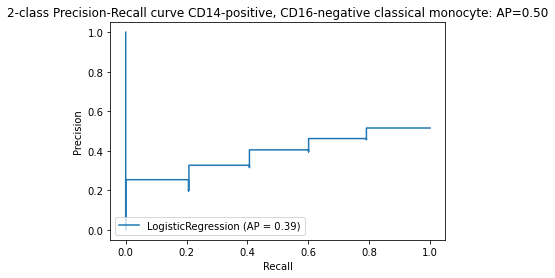

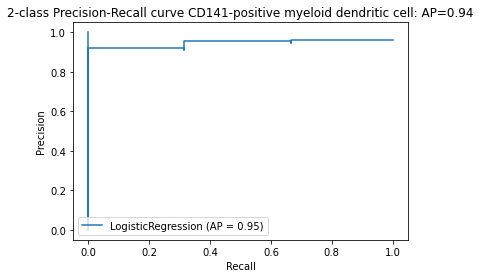

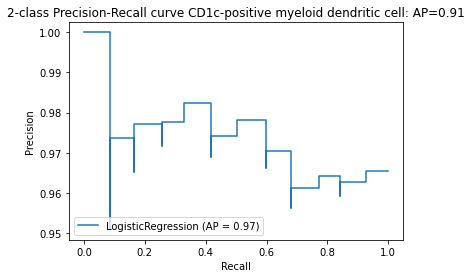

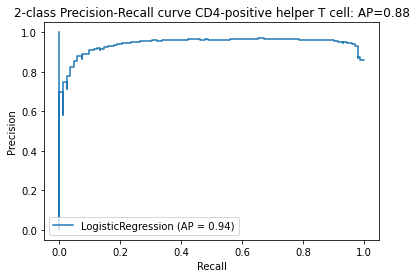

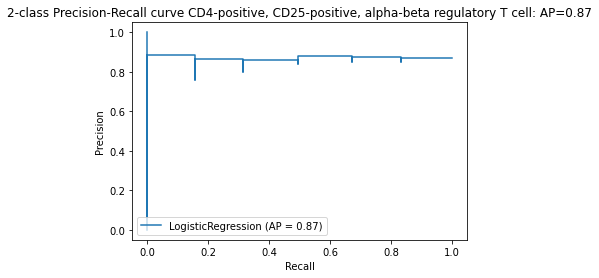

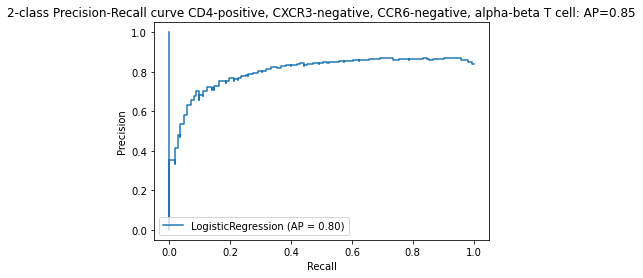

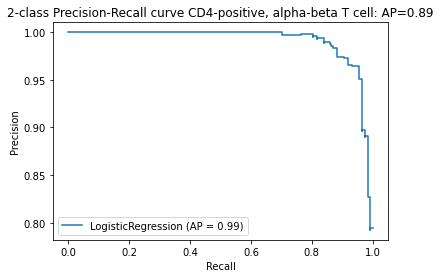

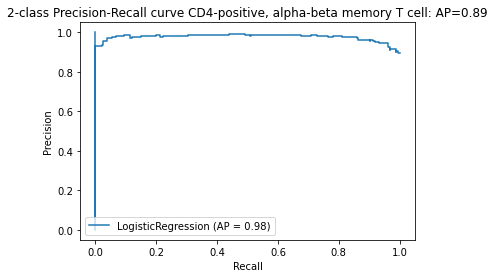

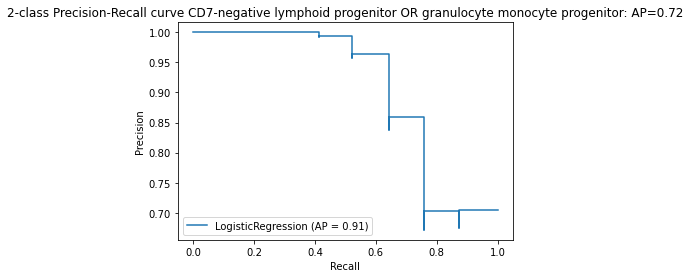

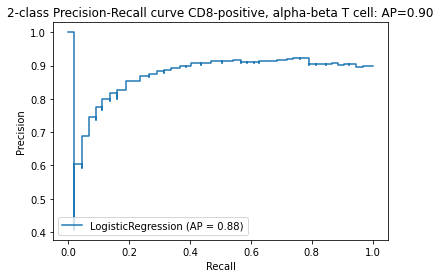

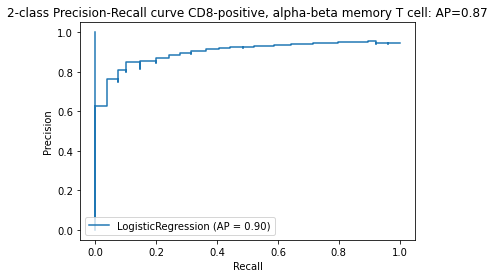

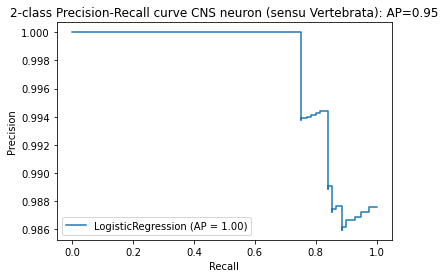

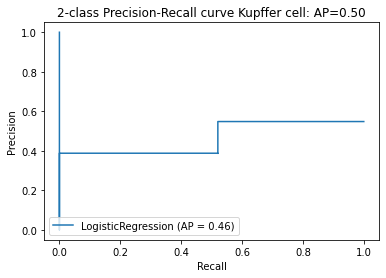

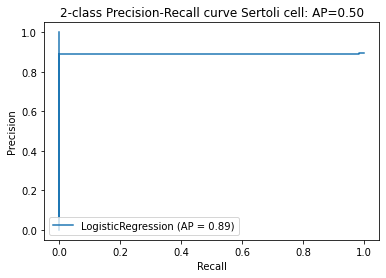

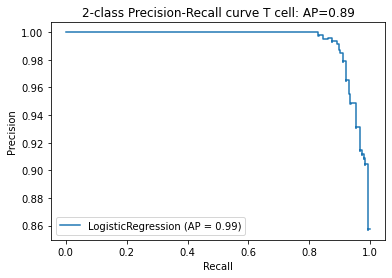

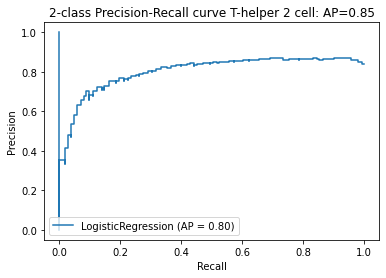

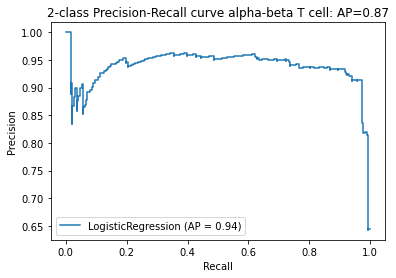

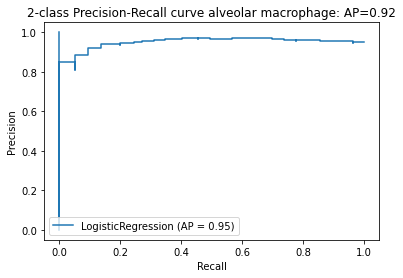

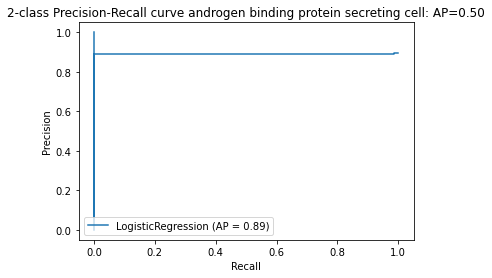

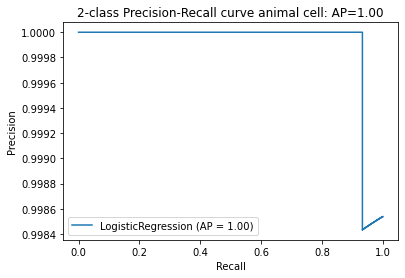

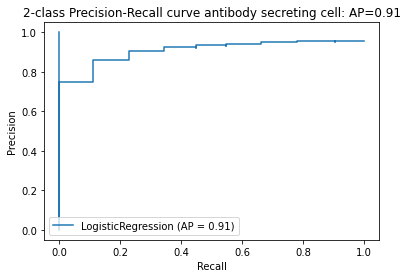

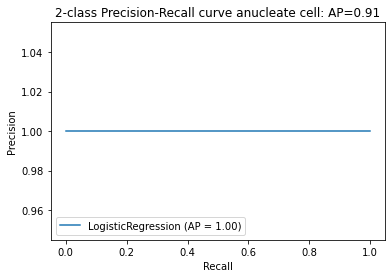

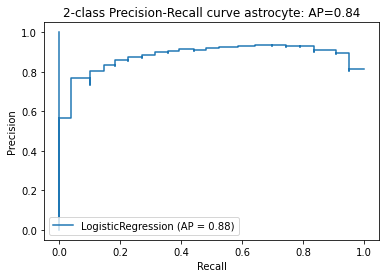

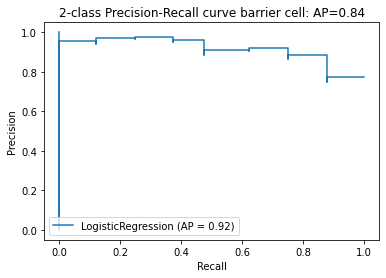

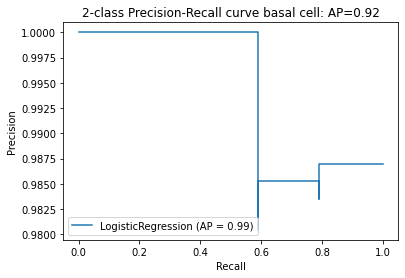

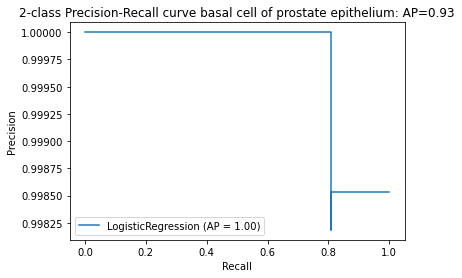

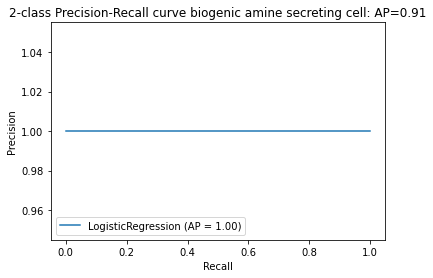

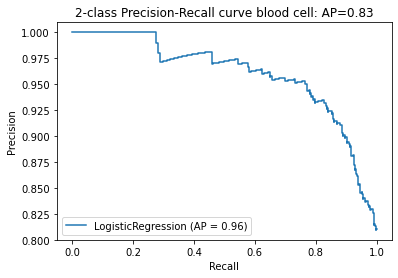

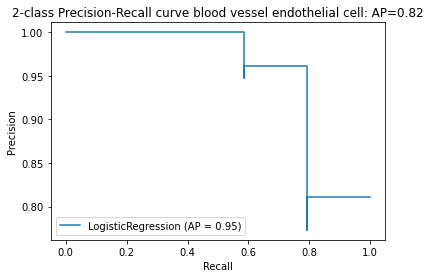

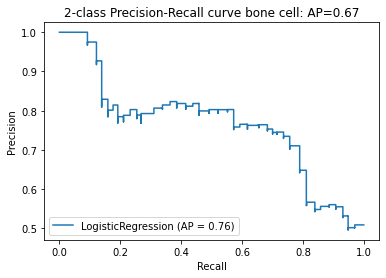

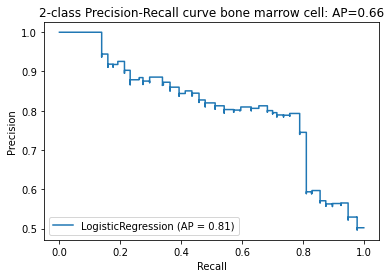

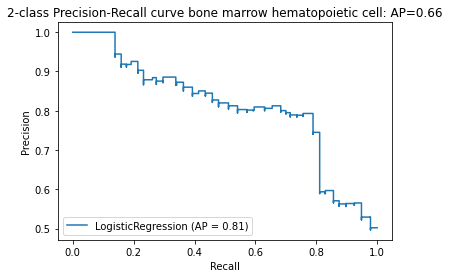

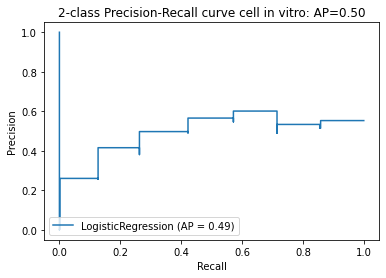

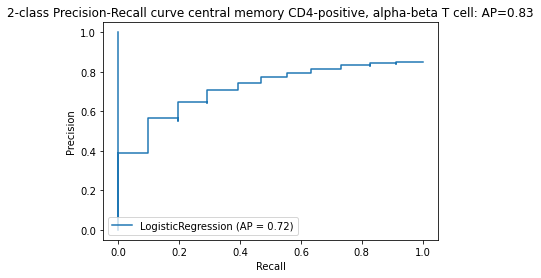

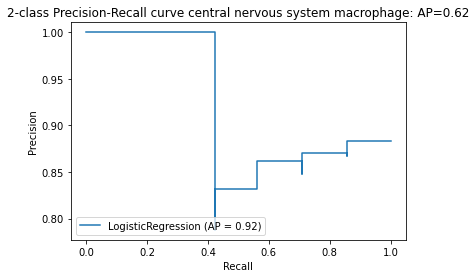

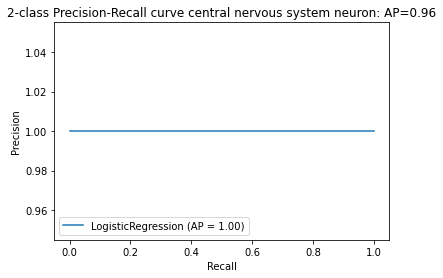

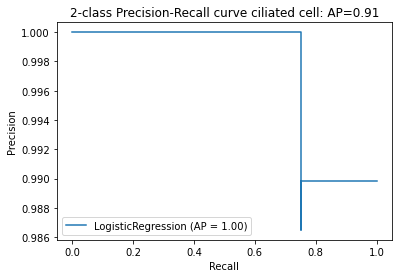

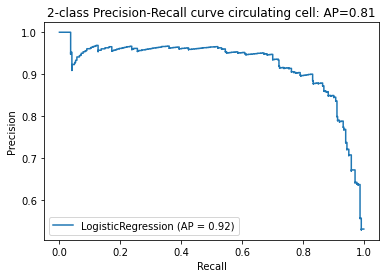

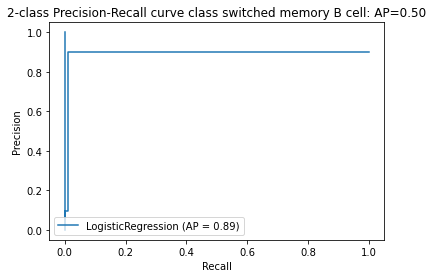

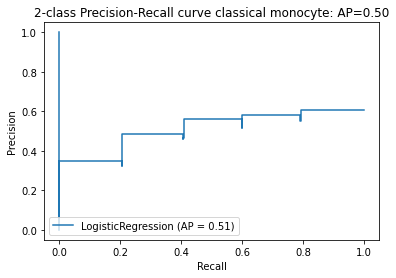

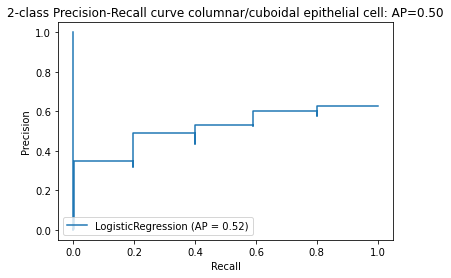

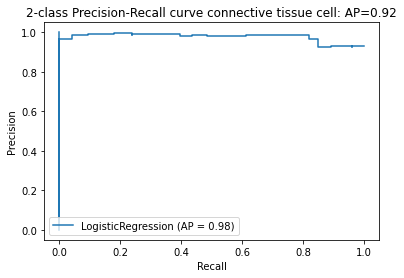

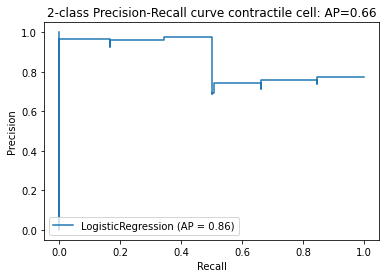

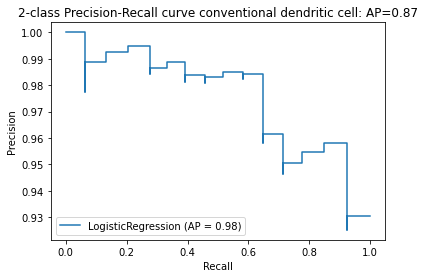

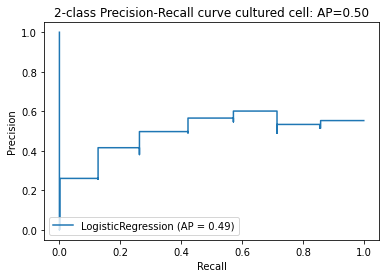

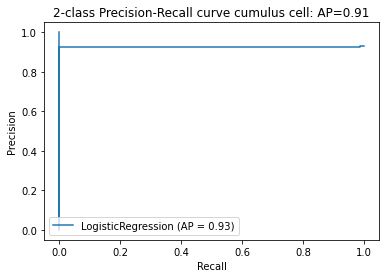

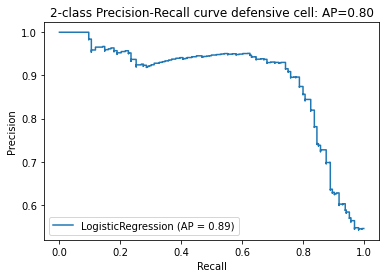

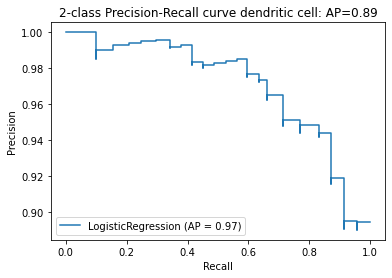

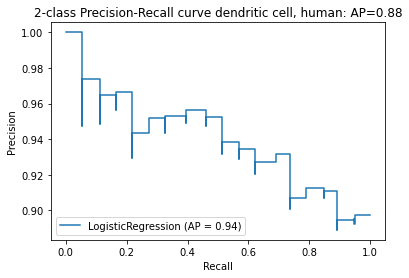

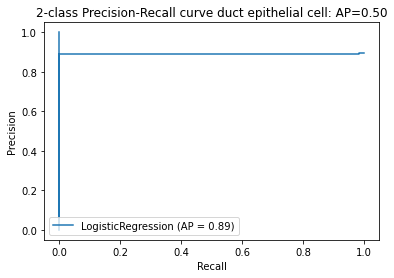

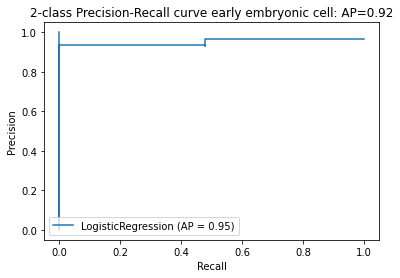

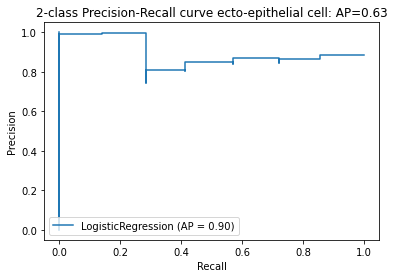

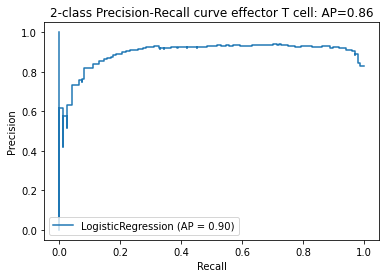

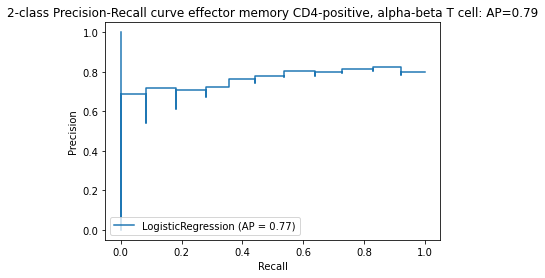

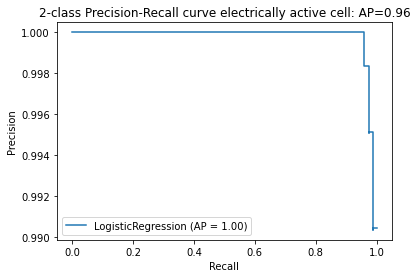

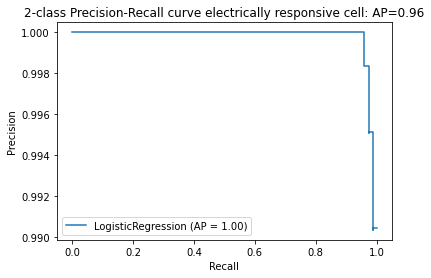

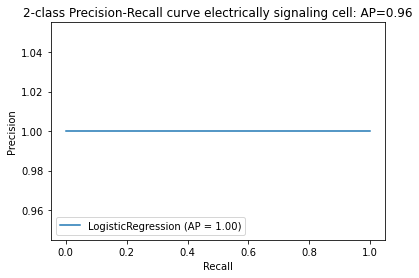

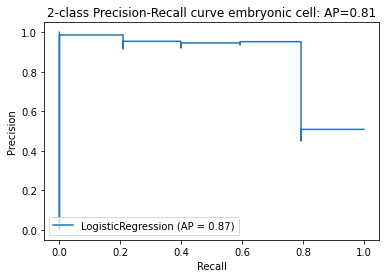

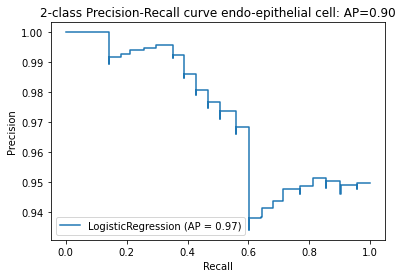

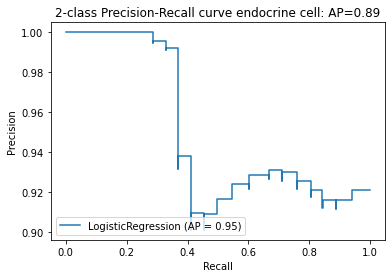

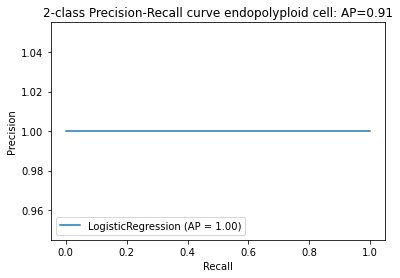

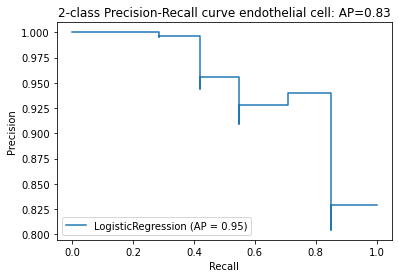

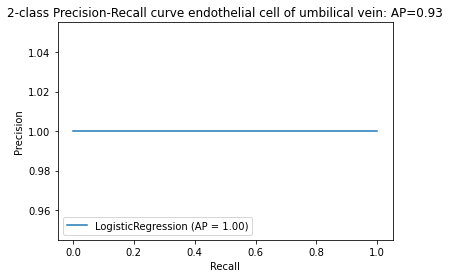

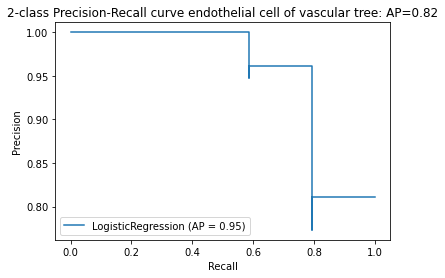

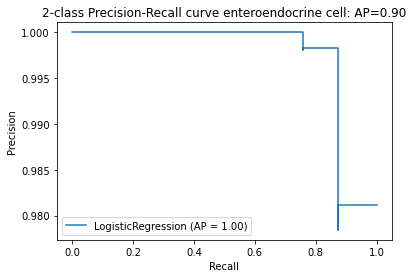

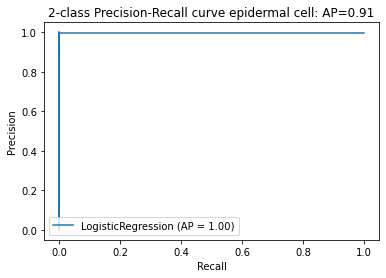

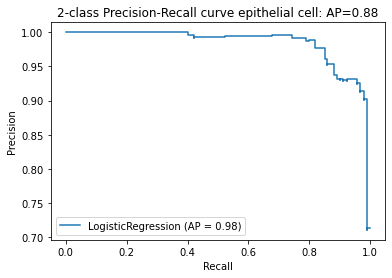

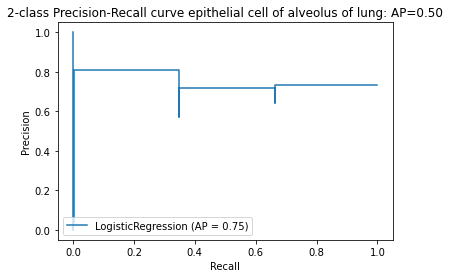

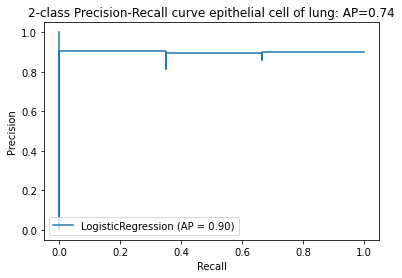

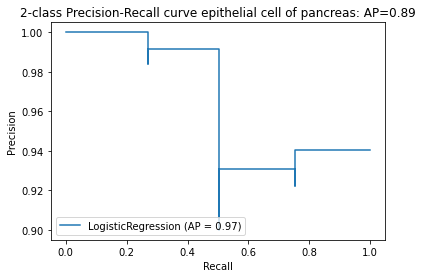

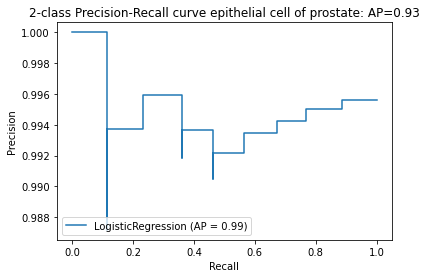

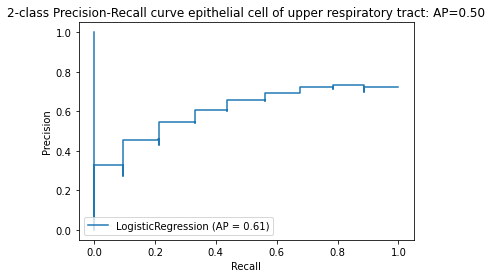

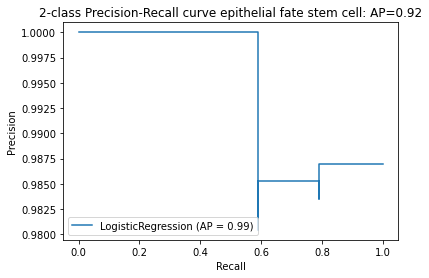

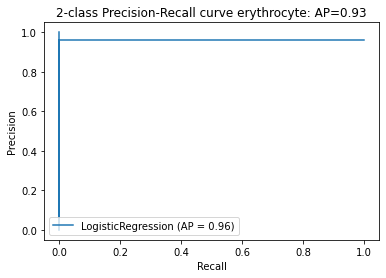

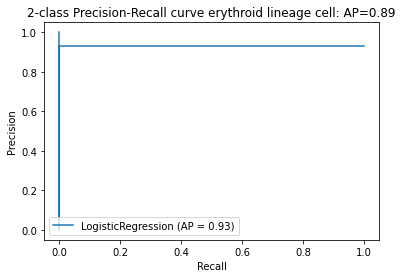

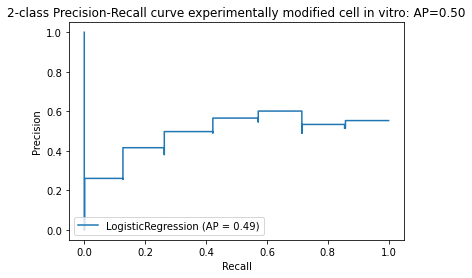

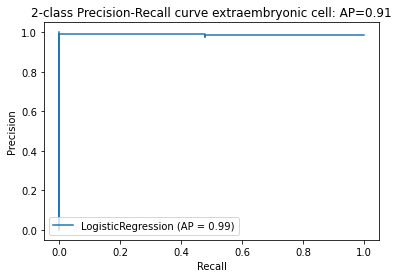

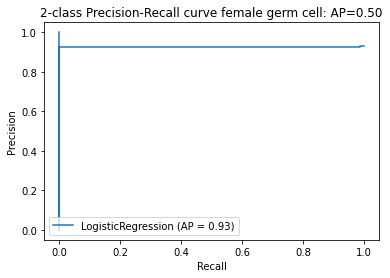

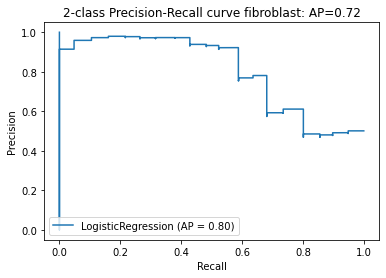

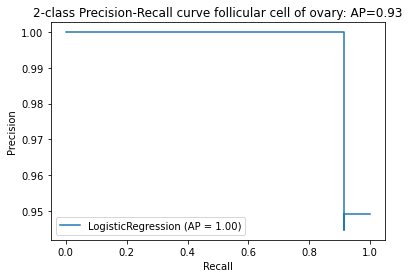

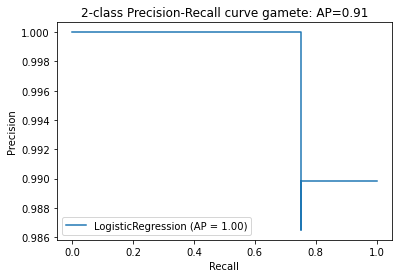

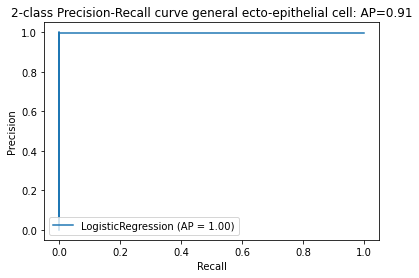

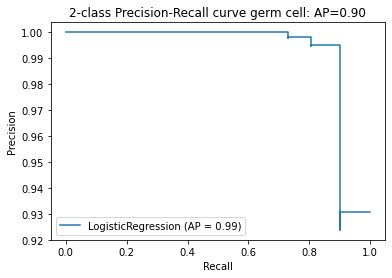

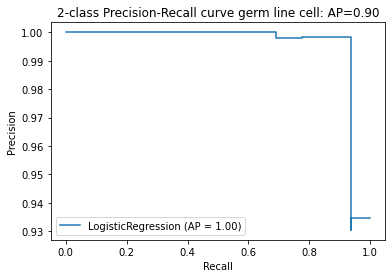

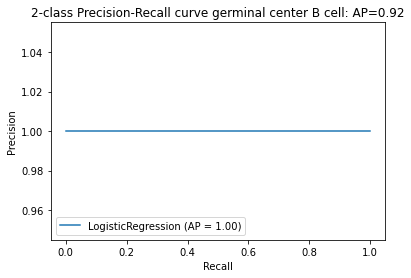

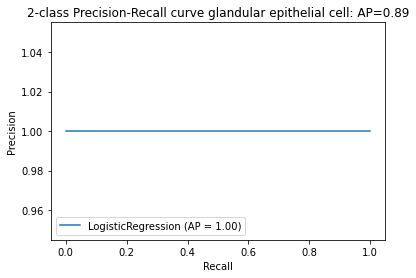

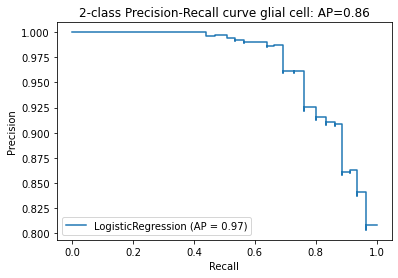

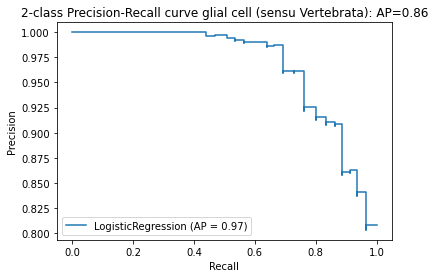

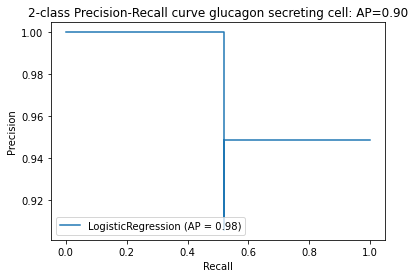

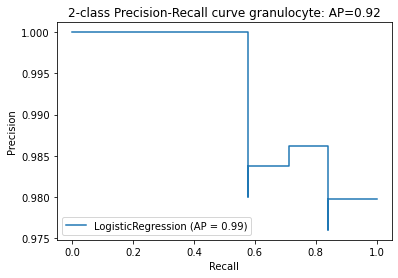

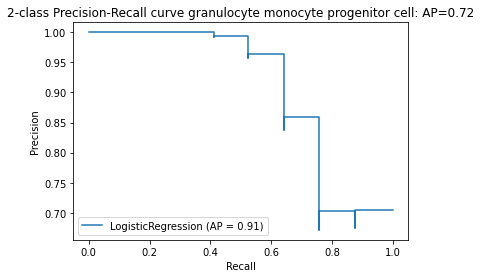

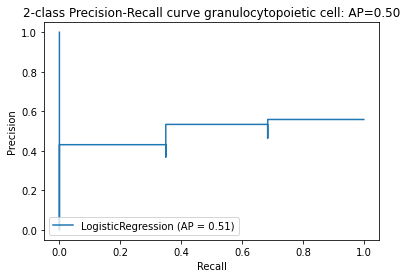

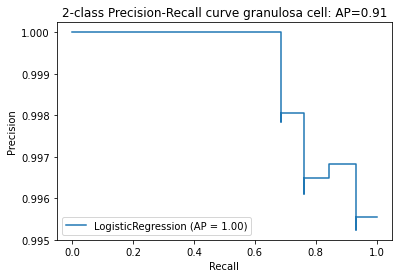

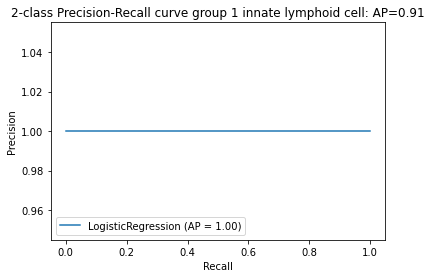

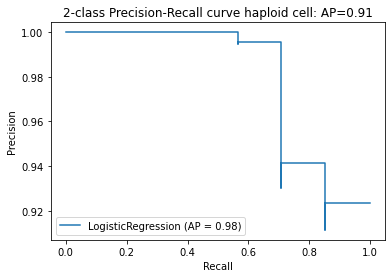

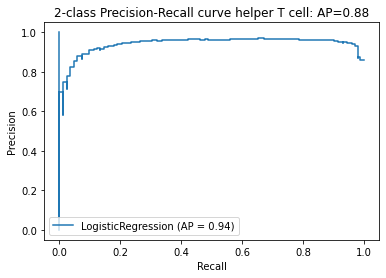

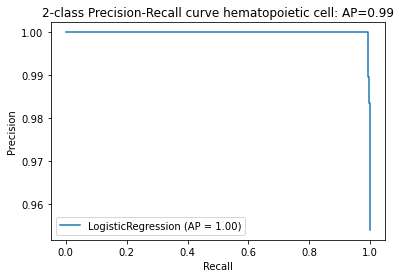

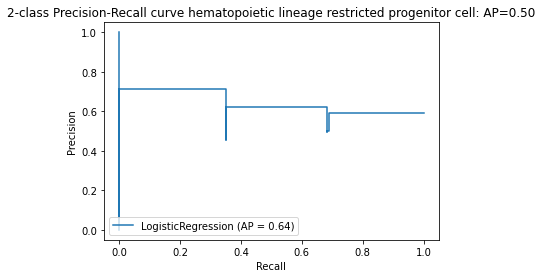

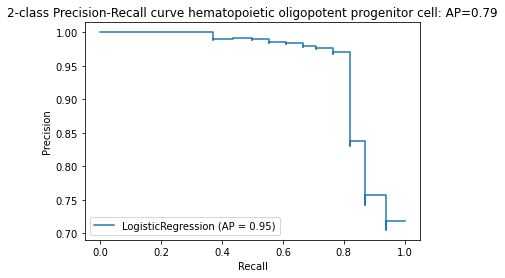

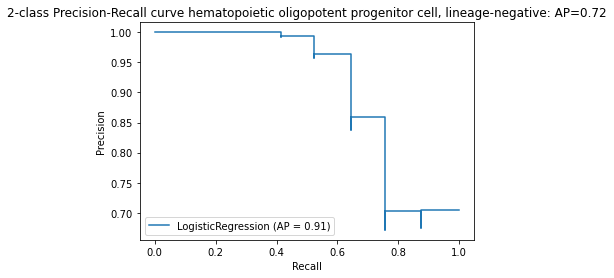

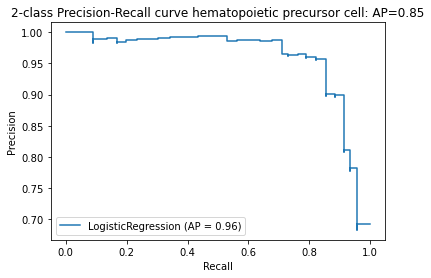

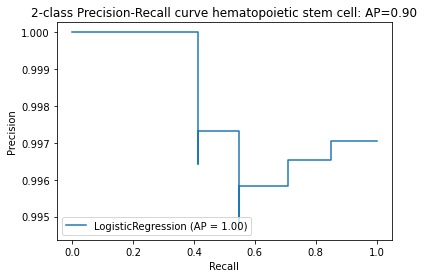

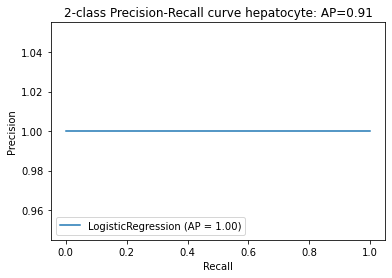

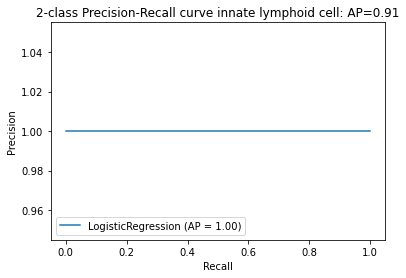

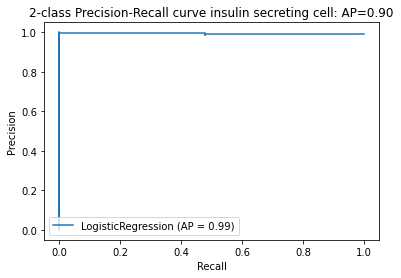

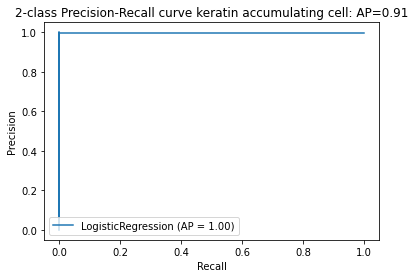

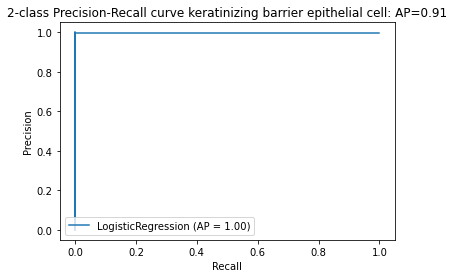

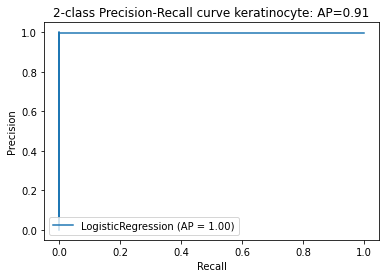

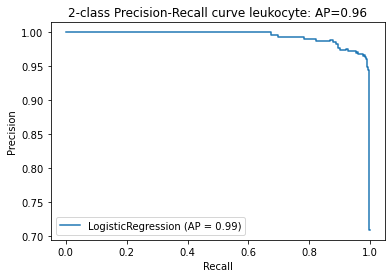

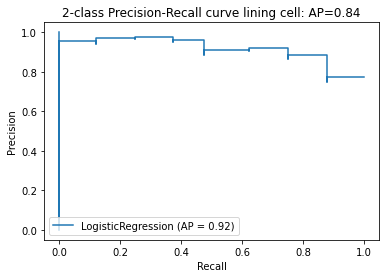

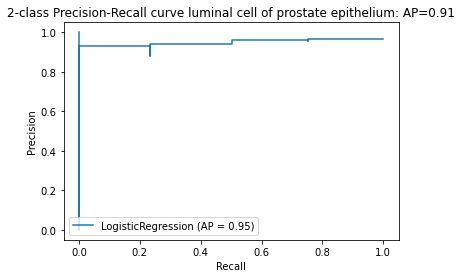

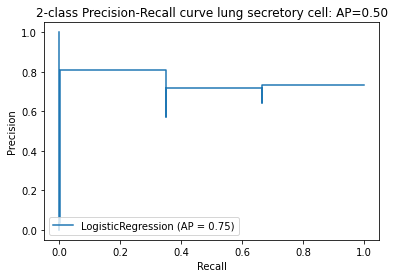

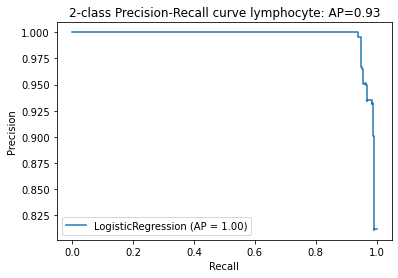

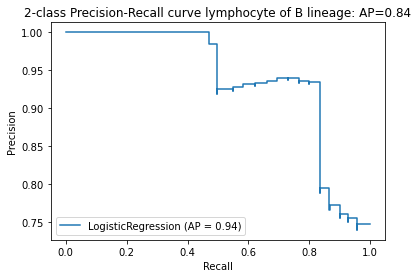

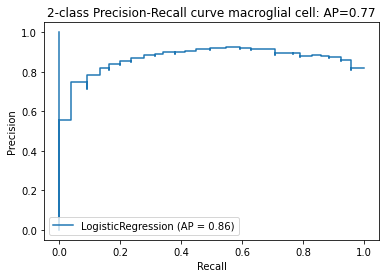

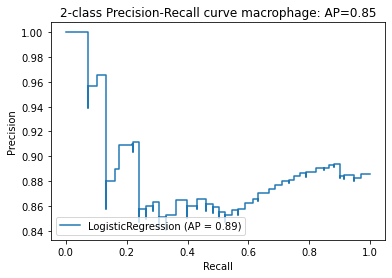

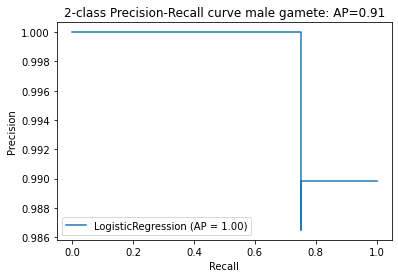

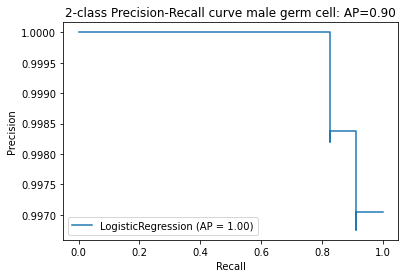

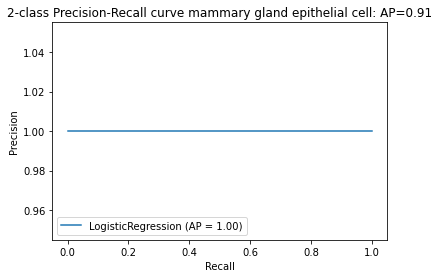

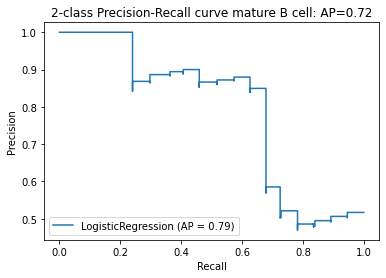

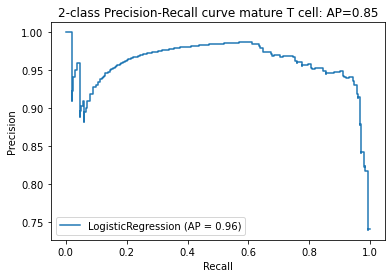

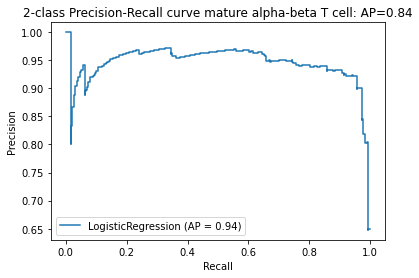

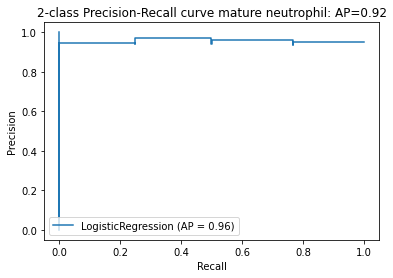

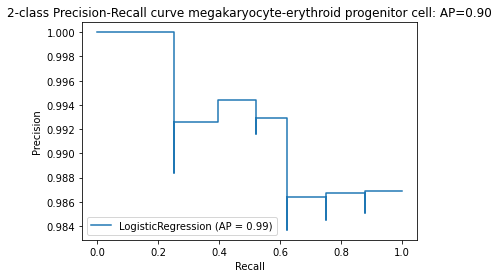

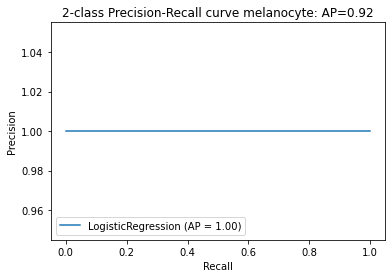

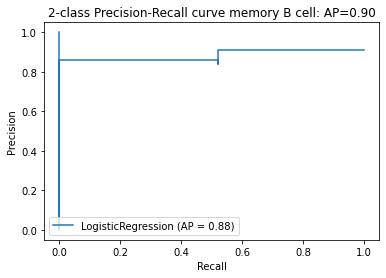

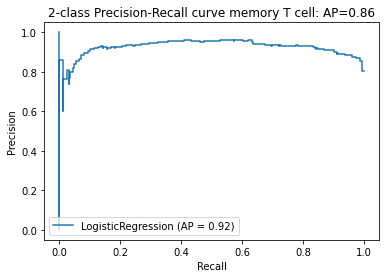

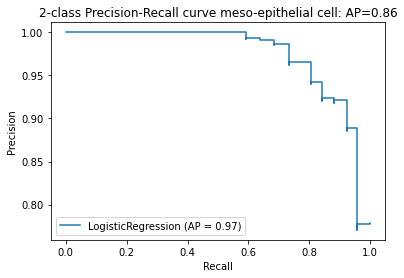

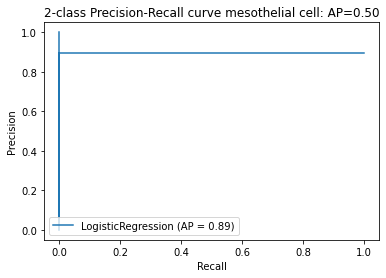

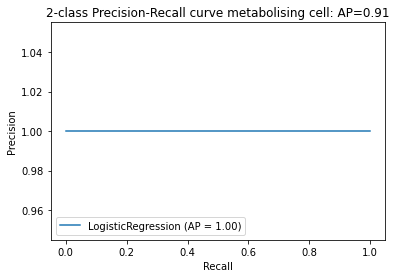

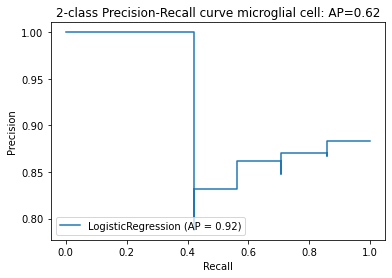

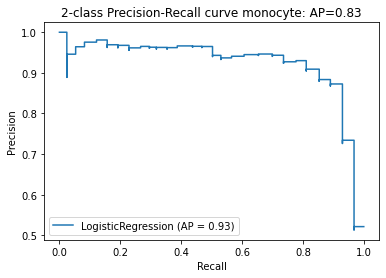

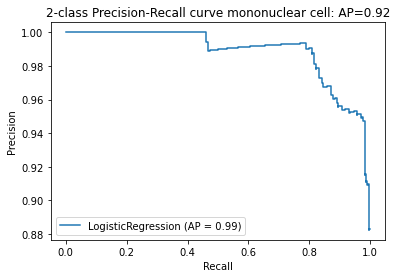

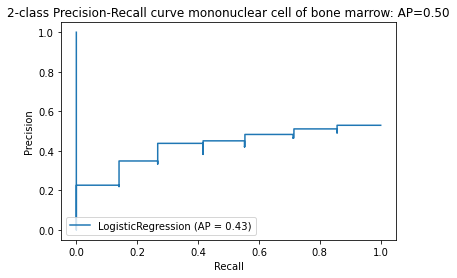

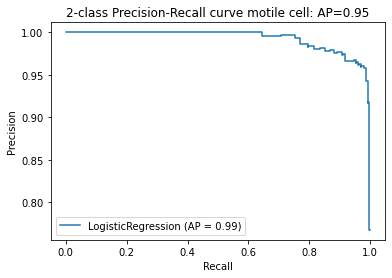

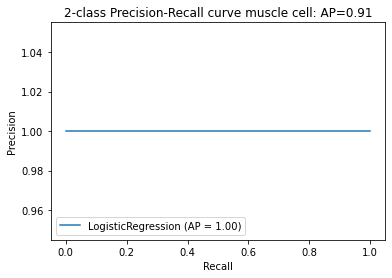

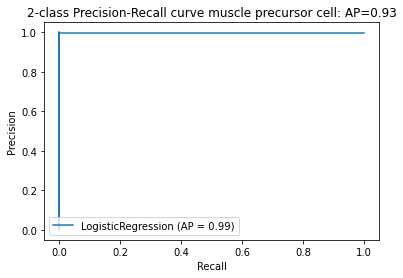

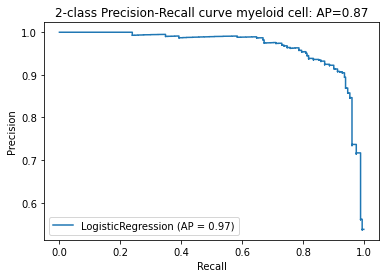

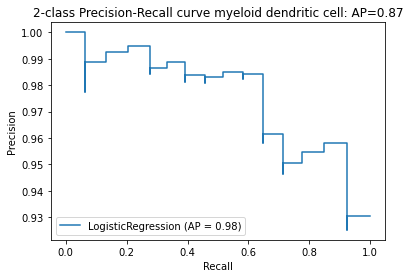

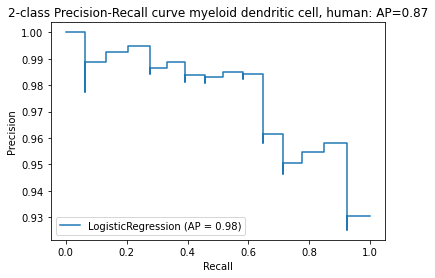

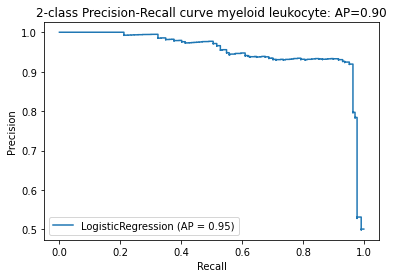

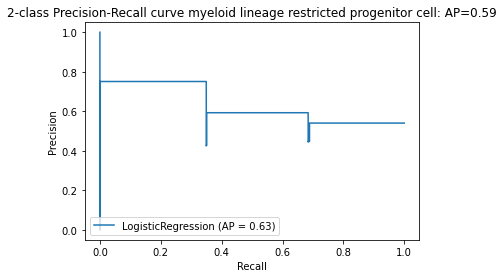

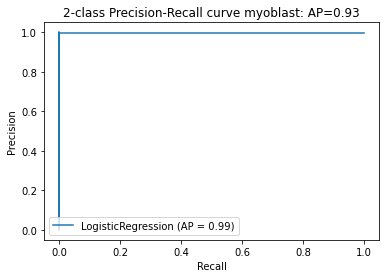

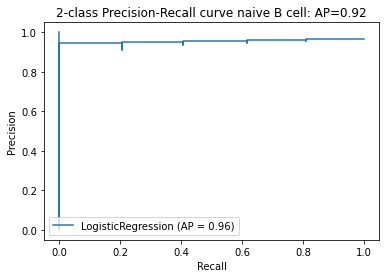

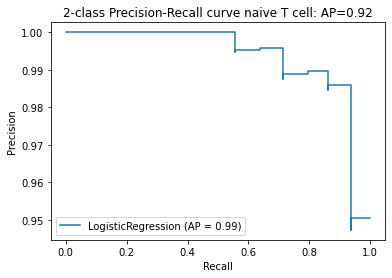

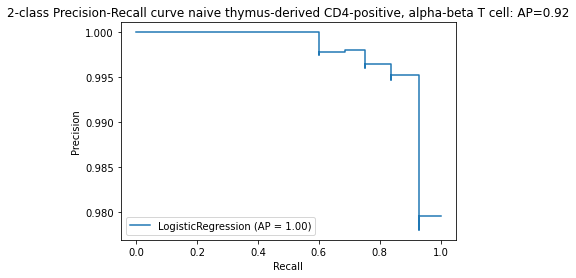

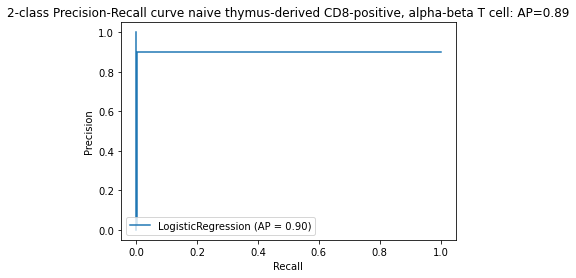

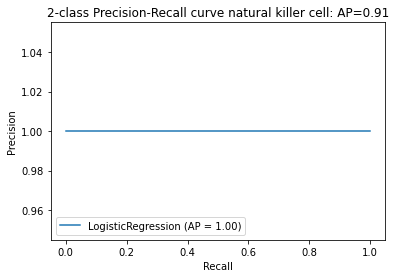

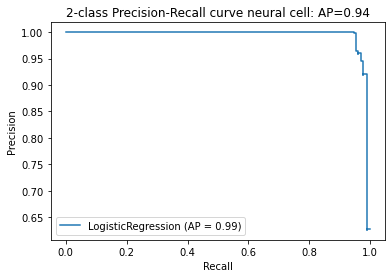

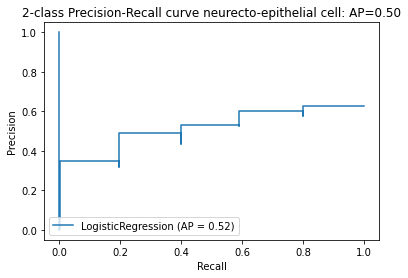

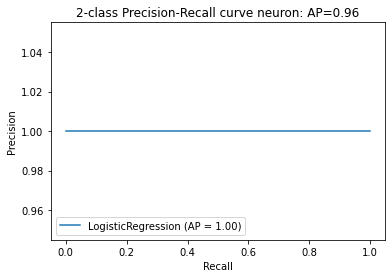

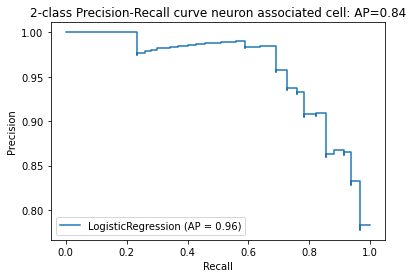

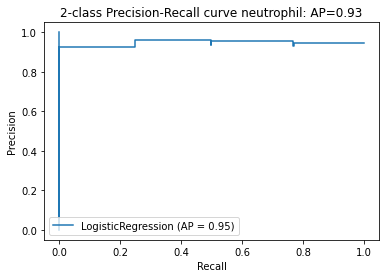

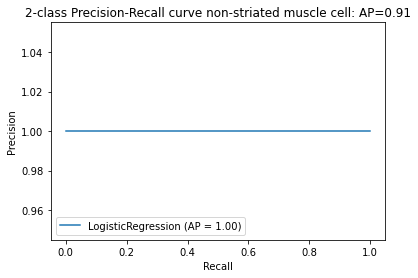

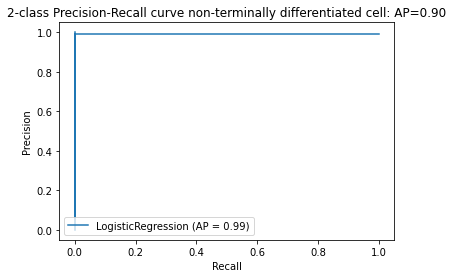

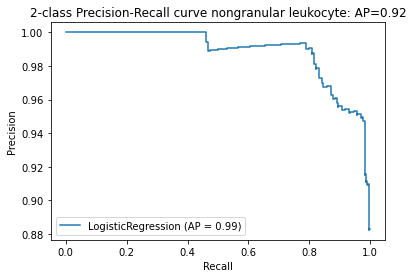

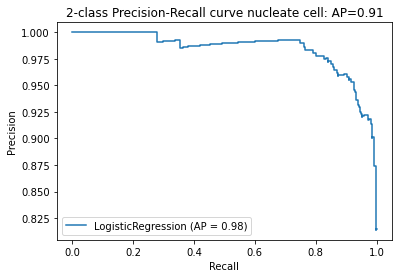

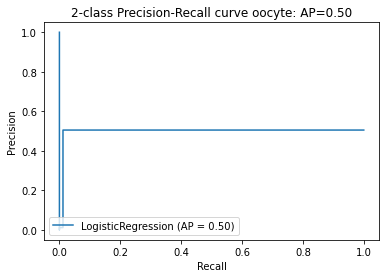

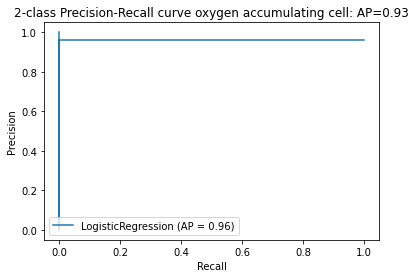

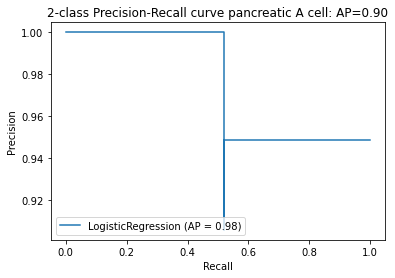

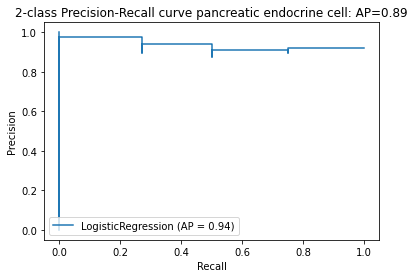

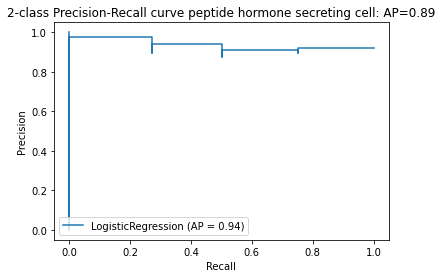

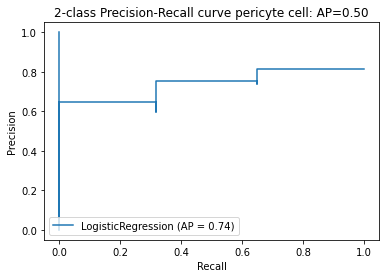

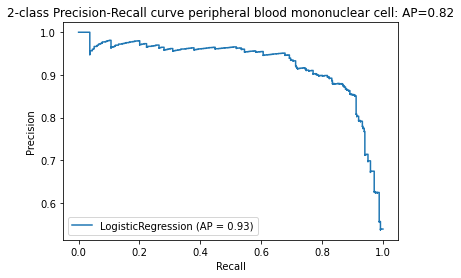

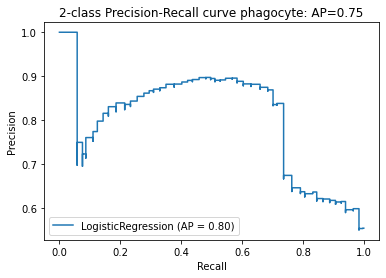

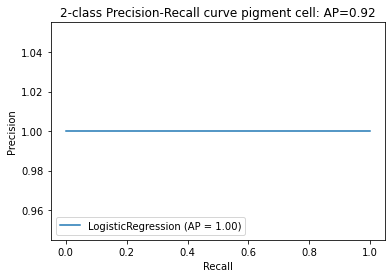

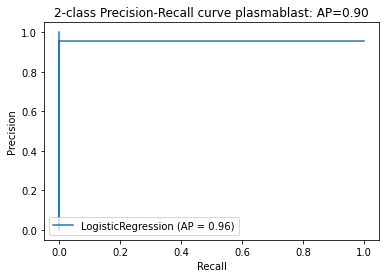

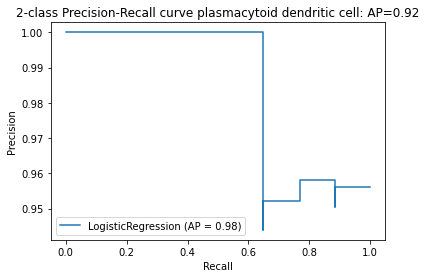

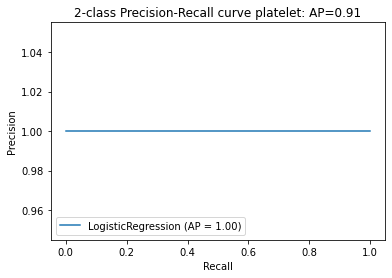

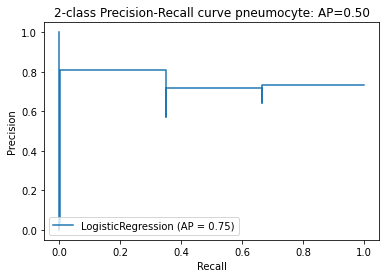

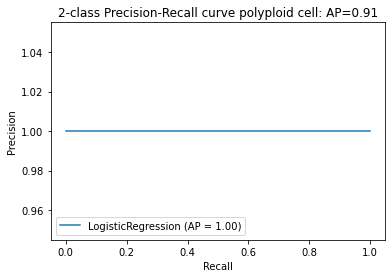

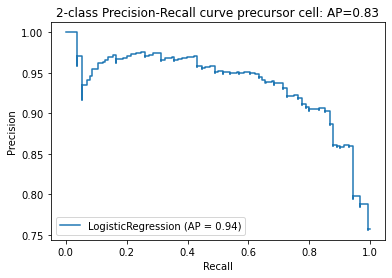

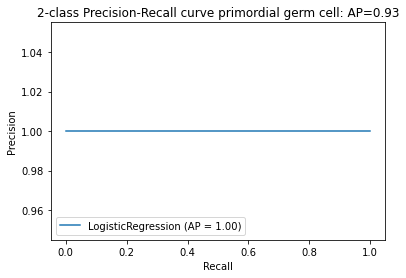

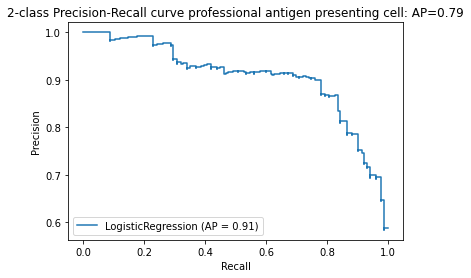

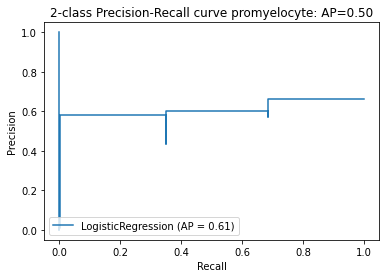

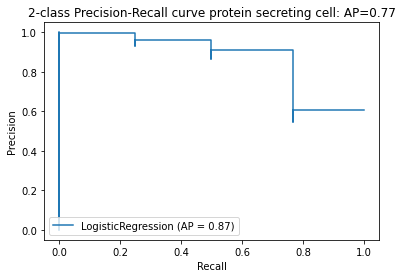

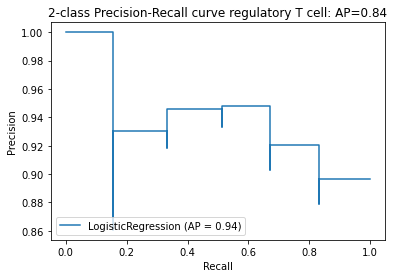

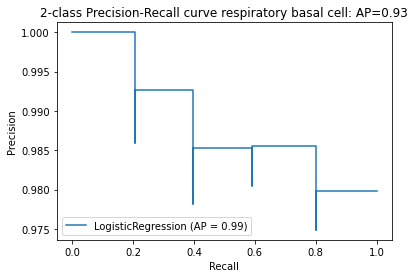

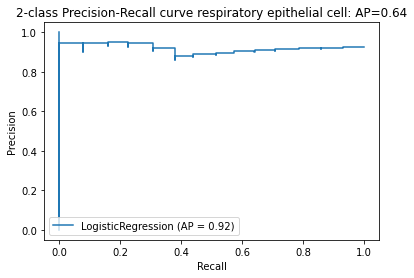

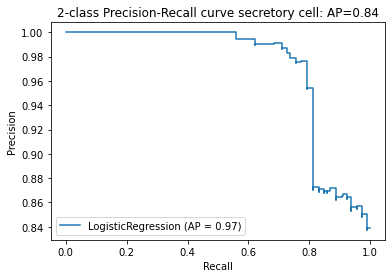

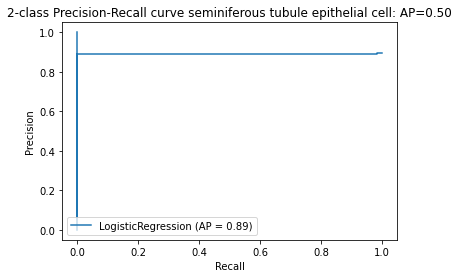

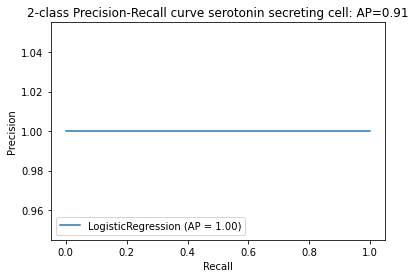

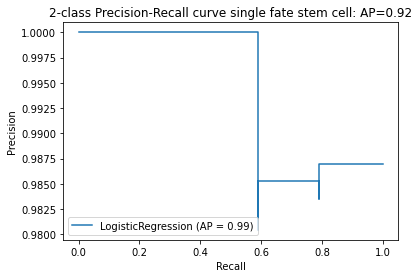

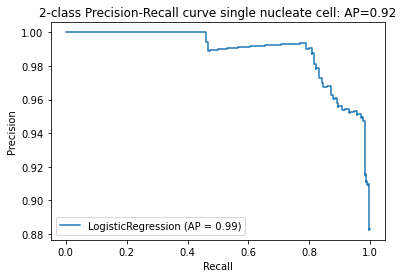

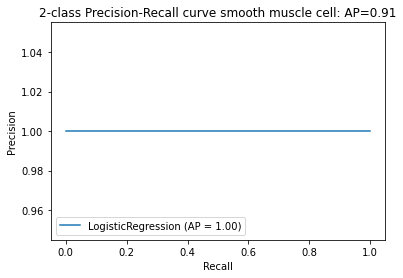

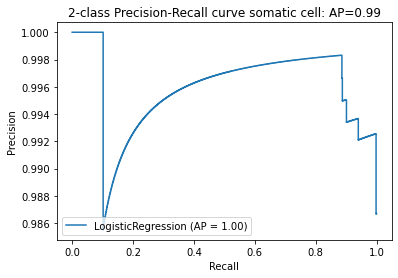

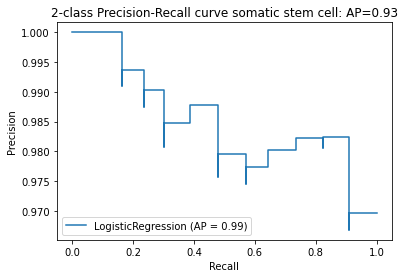

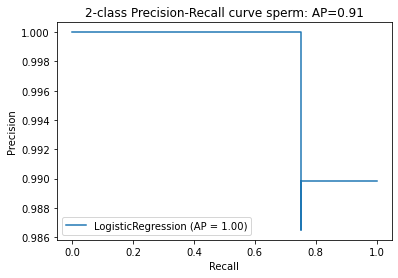

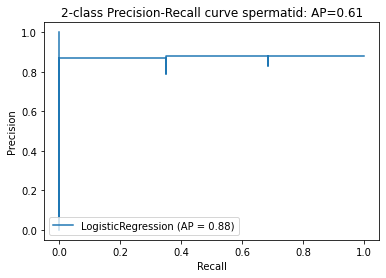

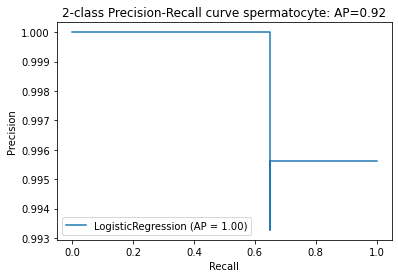

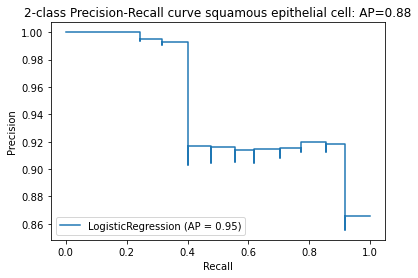

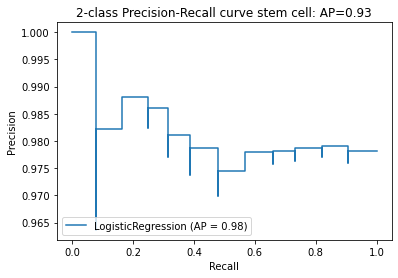

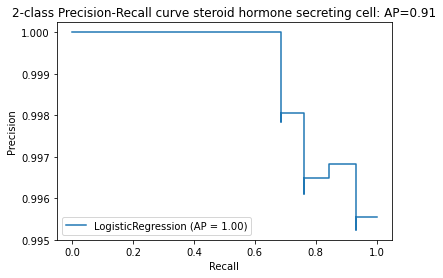

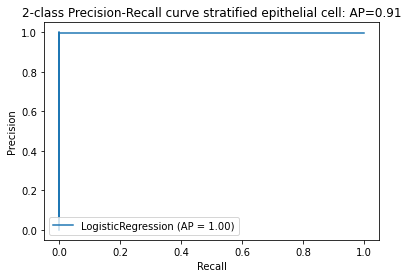

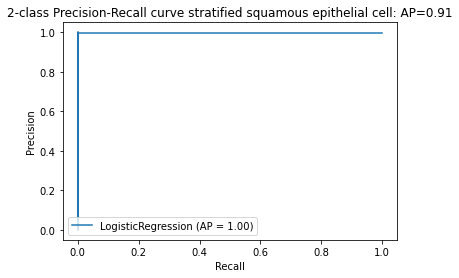

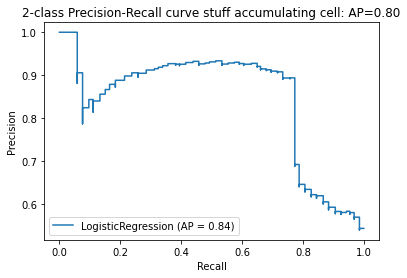

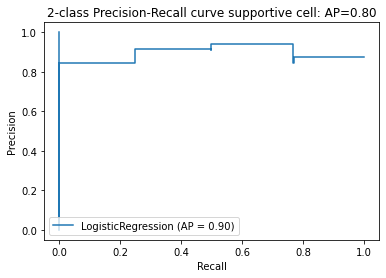

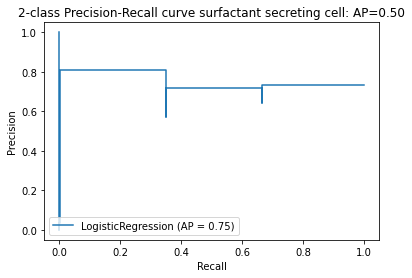

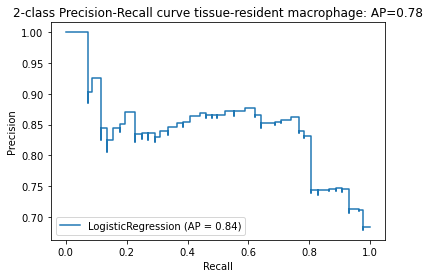

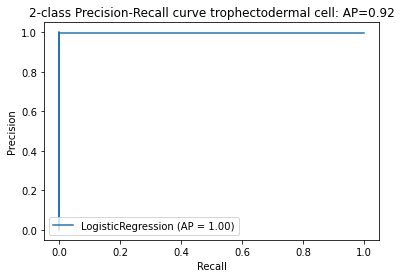

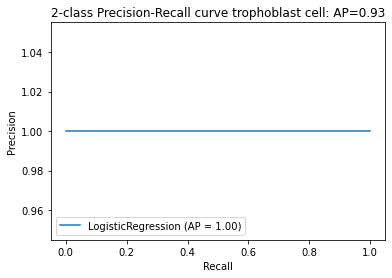

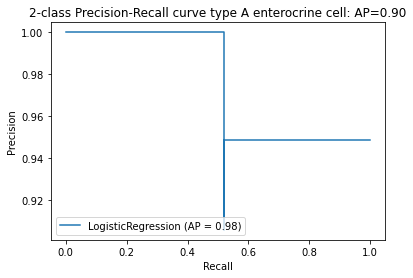

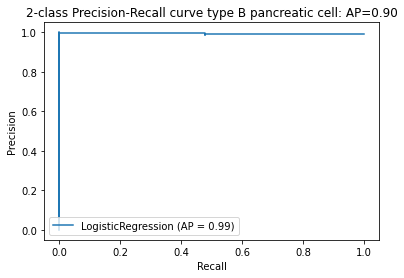

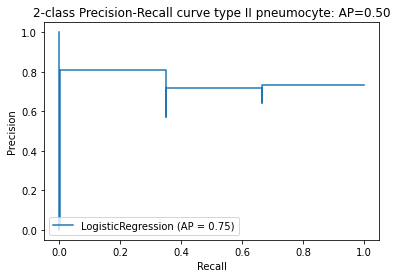

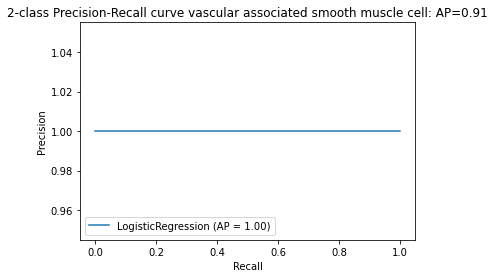

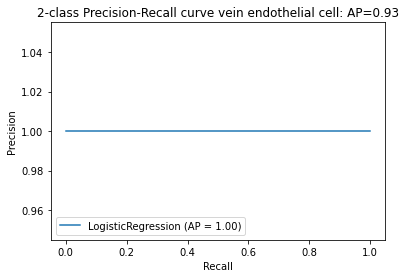

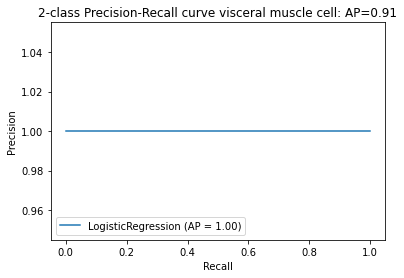

In [13]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
import numpy as np
import warnings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore') #gets rid of sklearn convergence warning

successful_celltypes =[]
unsuccessful_celltypes = []
test_prs = []
test_precision = []
test_recall = []
fscores = []
for cell_type in celltypes:
    train_target, train_test, train_data , test_data = set_target(cell_type ,type2samples, train_Y_df, test_Y_df, oversample = True )
    
    if(1 in train_target and 1 in train_test and 0 in train_target and 0 in train_test):
        # lasso penalty
        clf = LogisticRegression(solver = "saga",penalty = "l1",random_state=111 )
        
        clf.fit(train_data, train_target)
        target_pred= clf.predict(test_data)
        test_pr = metrics.average_precision_score(train_test, target_pred)
        test_precision += [precision_score(train_test, target_pred)]
        test_recall += [recall_score(train_test, target_pred)]
        fscores += [fscore(test_precision[-1], test_recall[-1])]
        successful_celltypes += [cell_type]
        #plot precision recall curve for celltype
        disp = plot_precision_recall_curve(clf, test_data, train_test)
        disp.ax_.set_title('2-class Precision-Recall curve '+str(cell_type)+': AP={0:0.2f}'.format(test_pr))
    else:
        unsuccessful_celltypes += [cell_type]
        
p = np.mean(test_precision)
r = np.mean(test_recall)
f = np.mean(fscores)
f_micro = fscore(p, r) 

report = pd.DataFrame(list(zip(successful_celltypes,test_precision,test_recall, fscores)),columns = ["celltype","precision score","recall score","f score"])


In [14]:
print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

precision: 0.7830, recall: 0.8035, f1: 0.3942, f1 micro avg: 0.3966


In [15]:
report

,celltype,precision score,recall score,f score
0,B cell,0.887500,0.747368,0.405714
1,CD14-positive monocyte,0.863905,0.890244,0.438438
2,"CD14-positive, CD16-negative classical monocyte",0.000000,0.000000,0.000000
3,CD141-positive myeloid dendritic cell,0.935440,1.000000,0.483322
4,CD1c-positive myeloid dendritic cell,0.905660,1.000000,0.475248
...,...,...,...,...
204,type B pancreatic cell,0.902116,1.000000,0.474270
205,type II pneumocyte,0.000000,0.000000,0.000000
206,vascular associated smooth muscle cell,0.910428,1.000000,0.476557
207,vein endothelial cell,0.929059,1.000000,0.481612


In [16]:
print(len(unsuccessful_celltypes))
unsuccessful_celltypes

108


['Bm4 B cell',
 'CD14-low, CD16-positive monocyte',
 'CD14-positive, CD16-positive monocyte',
 'CD4-positive, alpha-beta thymocyte',
 'CD8-positive, alpha-beta thymocyte',
 'IgD-negative memory B cell',
 'IgG memory B cell',
 'IgM memory B cell',
 'Merkel cell',
 'T follicular helper cell',
 'T-helper 1 cell',
 'T-helper 17 cell',
 'activated CD4-positive, alpha-beta T cell',
 'activated CD4-positive, alpha-beta T cell, human',
 'adult endothelial progenitor cell',
 'angioblastic mesenchymal cell',
 'basophil',
 'brain microvascular endothelial cell',
 'brain pericyte',
 'carbohydrate secreting cell',
 'cell',
 'central memory CD8-positive, alpha-beta T cell',
 'central nervous system pericyte',
 'cerebellar granule cell',
 'cerebellar neuron',
 'chondrocyte',
 'collagen secreting cell',
 'common lymphoid progenitor',
 'common myeloid progenitor',
 'common myeloid progenitor, CD34-positive',
 'cord blood hematopoietic stem cell',
 'corneal endothelial cell',
 'corona radiata cell',
 'd